[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/upm-classes/image-understanding-2021-2022/blob/main/IU_classification.ipynb)

# Image Understanding
Image understanding (IU) focuses on the basis of image analysis in combination with artificial intelligence to further study the nature of image objects and their interconnections, understand the meaning of image content, and interpret the corresponding objective scenarios to guide and plan further actions. [<sup>1</sup>](#fn1)



## Define an Objective for your Project

The most important step to any project is to establish a clear objective to achieve. Your objective may vary widely based on your specific use case. It will determine the type and quantity of data required for an image dataset. Remember that the purpose of our IU project is to create data-driven system or better said image-driven system. Here are some common IU objectives:

![Image of IU objectives](https://raw.githubusercontent.com/upm-classes/image-understanding-2021-2022/main/images/project_01.jpg)

- **Classification**:  Its goal is to use the raw visual data contained within an image to assign a certain conceptual label, or “class” to that image. 
- **Detection**: It is the process consisting at finding specific objects and localizing them to a certain area within an image. If you care where in an image the object is found, this is your objective.
- **Segmentation**: It is an advanced form of detection that occurs at pixel-level. Its purpose is to segment objects in an image according to their exact boundaries and separate them from each other.

For this project, since it is the "easiest" we are going to focus on and image classification project.

## Project data

Collecting and organizing a high-quality image data set is a critical step our project. This step can make or break a fledgling system. We are going to use machine learning (ML) models to classiffy our images,  but remember that ML model can produce exceptional insight, but only when they are fueled by high-quality, well-labeled, relevant data that accurately encapsulates the problem space.

In the case of data-driven projects, as ours, it is important to remember this motto: **garbage in = garbage out**.

Some desirable aspects that our dataset should have are: 
- Quantity: the dataset have a sufficient volume of images.
- Diversity: dataset's images come from a diverse set of perspectives, colors, or orientations.
- Accuracy: the dataset have relevant images and accurate labels.
- Quality: the right images in high-quality resolution are in the dataset.

Data can be collected, you can take all pictures or scrap them from internet but this is a time-demanding process, that generally implies to annotate all pictures (i.e., providing a label/class to each image). Even it can be created artificially, using novel techniques such as [GANs](https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf), but this is beyond the scope of this course. However most of the time you have to deal with a dataset created by others. This will be our case.

In [80]:
# Libraries for use in a conda environment with comments on how to install them

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread

#!pip install umap-learn[plot]
#!pip install holoviews
#!pip install -U ipykernel

#import umap 
#import umap.plot
import os
import io
import glob

from sklearn.model_selection import train_test_split

# For SVM model
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from joblib import dump, load

### Get the data

In [8]:
# Download Dataset
!wget https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv -O mnist_train_small.csv

--2022-02-28 13:47:21--  https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 74.125.31.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36523880 (35M) [application/octet-stream]
Saving to: ‘mnist_train_small.csv’

mnist_train_small.c 100%[===================>]  34.83M   214MB/s    in 0.2s    

2022-02-28 13:47:21 (214 MB/s) - ‘mnist_train_small.csv’ saved [36523880/36523880]



#### Data preparation
In this case, it is needed since images were saved as csv files.

In [49]:
mnist_dataframe = pd.read_csv(
  io.open('./mnist_train_small.csv', 'r'),
  sep=',',
  header=None)

# Use just the first 10,000 records.
mnist_dataframe = mnist_dataframe.head(10000)

# Randomize records
mnist_dataframe = mnist_dataframe.reindex(
    np.random.permutation(mnist_dataframe.index))


def parse_labels_and_features(dataset):
  """Extracts labels and features.
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset[0]

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.loc[:,1:784]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features

  return features, labels 

### Data exploration

An important step when dealing with an unfamiliar dataset is to understanding it. This implies to visualize it, find outliers, and know the characteristics of the image. 

Check this link: https://knowyourdata-tfds.withgoogle.com

In [ ]:
# X correspond to the features in this case pixels, and y 
# corresponds to the labels (classes)
X, y = parse_labels_and_features(mnist_dataframe) 

display(X.head())
display(y.head())

#### Visualization

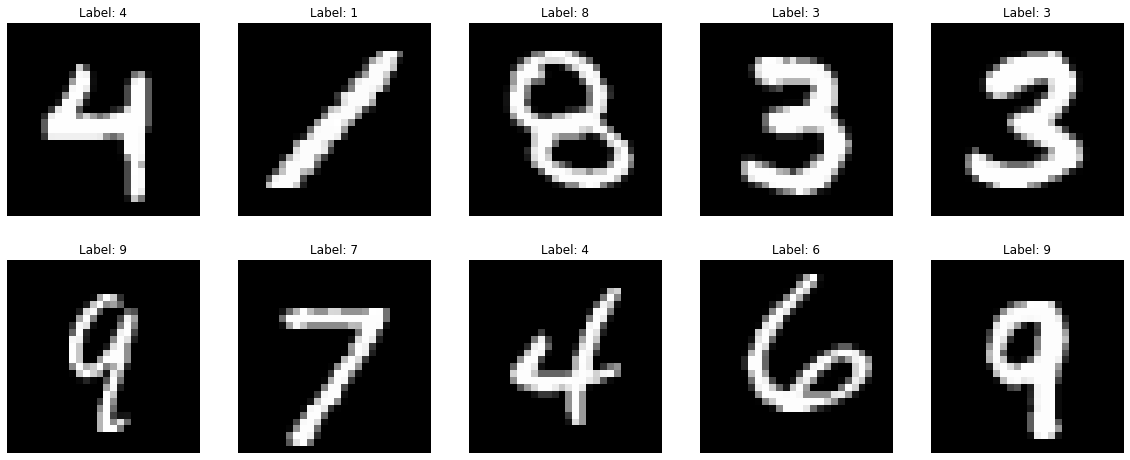

In [70]:
# Visualization of 10 random samples

num_samples = 10
rand_samples = np.random.choice(X.index, num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = X.loc[rand_samples[i]].values.reshape(28, 28)
    label = y.loc[rand_samples[i]]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
    ax.imshow(im, cmap='gray')
plt.show()

#### Distribution of classes

Information about classes:
Class: 0, number of samples: 979
Class: 1, number of samples: 1107
Class: 2, number of samples: 1001
Class: 3, number of samples: 981
Class: 4, number of samples: 943
Class: 5, number of samples: 894
Class: 6, number of samples: 1021
Class: 7, number of samples: 1085
Class: 8, number of samples: 973
Class: 9, number of samples: 1016


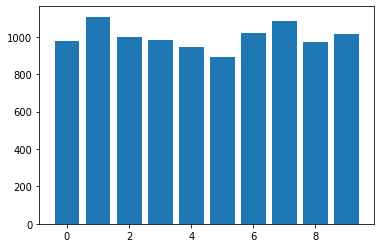

In [48]:
print('Information about classes:')

classes = np.unique(y.values)
description = np.array([(c, np.sum(y == c)) for c in classes])

for desc in description:
    print('Class: {}, number of samples: {}'.format(desc[0], desc[1]))

plt.bar(description[:,0], description[:,1].astype(int))
plt.show()

### Preprocessing
After having a clear idea of the data, it is necesarry to perform some tasks that could help to our purpose such as dealing with the outliers, denoising, histogram matching.

In [50]:
# To be implemented

## Classification using only raw pixels

During the development of a project, it is usual to test different features, and their combinations, as well as different models. In order to evaluate which is the better you have to provide some indicators (eg. error metric). This process, it is usually a try-and-error process. However, it is important to remember that a model in which you can include prior knowledge of the problem will be always a better model.

In order to make a fair comparison the sets (train, test and validation) should be the same.

Here it is an example of using al the image pixels as a features. What is the disadvantage of doing this? This is the baseline.

In [57]:
seed = 23 # It is important to use a seed

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20, random_state=seed)
# Split train set into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=seed)

print('Training set shape: {}'.format(X_train.shape))
print('Validation set shape: {}'.format(X_test.shape))
print('Test set shape: {}'.format(X_test.shape))

Training set shape: (6400, 784)
Validation set shape: (1600, 784)
Test set shape: (1600, 784)


#### Model training

In [58]:
model = svm.SVC() # You can set the parameters
model.fit(X_train, y_train) # Fitting the model

dump(model, 'svm_model_pixels.joblib') # saving model
model = load('svm_model_pixels.joblib') # loading model

#### Assesment of the model

In [59]:
# Predict the value of the digit on the test subset
predicted = model.predict(X_test)

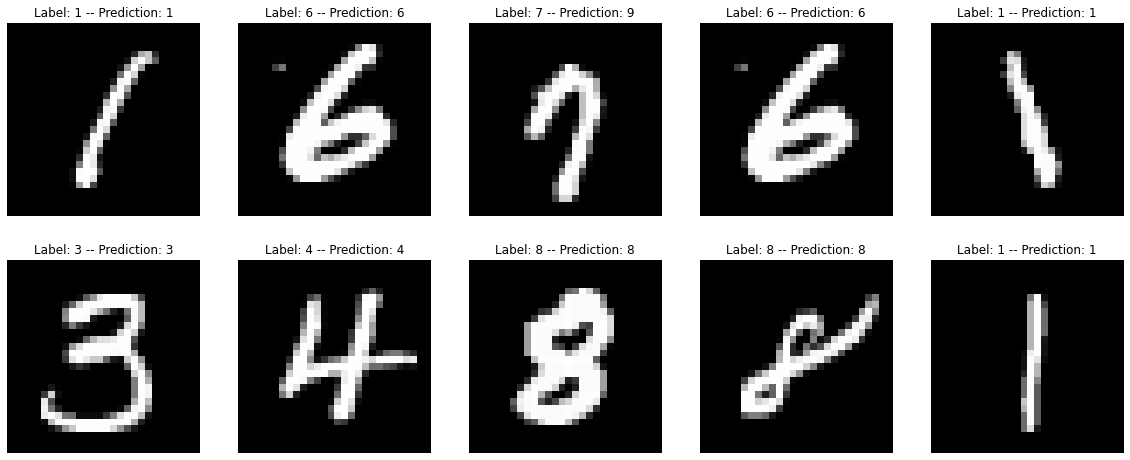

In [71]:
# Visualize some predictions

num_samples = 10

rand_samples = np.random.choice(np.arange(X_test.shape[0]), num_samples)

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    
    im = X_test[rand_samples[i]].reshape(28, 28)
    label = y_test[rand_samples[i]]
    predicted_label = predicted[rand_samples[i]]
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(f"Label: {label} -- Prediction: {predicted_label}")
    ax.axis('off')
    ax.imshow(im, cmap='gray')
plt.show()

In [77]:
print("Classification report for classifier")
print(f"{classification_report(y_test, predicted)}")

Classification report for classifier
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       169
           1       0.97      0.98      0.98       159
           2       0.96      0.97      0.96       163
           3       0.94      0.94      0.94       159
           4       0.93      0.99      0.95       150
           5       0.97      0.95      0.96       128
           6       0.98      0.98      0.98       172
           7       0.97      0.93      0.95       164
           8       0.95      0.93      0.94       165
           9       0.93      0.95      0.94       171

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600



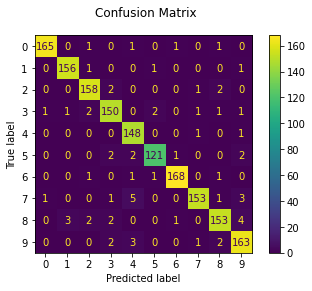

In [81]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
plt.show()